# Completeness Function Jupyter Notebook

In order to use the completeness function, we first need to execute all of the cells below. Once that's done, go [here](#here).

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as intg

## Widget based progress bar code from [GitHub](https://github.com/kuk/log-progress)

In [14]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Simulating an observation
This function generates an observation of a given length with a certain observing window duration. 

In [15]:
def sim_obs(obs_days, obs_window_length=8):
    """Generates an observation of N given days with a certain observing window duration for each day
    along with a list containing the data time stamps.
    
    Parameters:
    ----------
    obs_days: Number of observation days to simulate.
    obs_window_length: Lenght of the observing window in hours. Default is 8 hours.
    """
    global data # An empty list to which the simulated time stamps are appended to.
    data = [] 
    t_1 = 3600 #3,600 seconds in 1 hour.
    t_8 = 28800 #28,800 seconds in 8 hours.
    t_24 = 86400 #86,400 seconds in 24 hours.
    n_days = obs_days #The plus 1 is to incoorporate the entire day including the gaps for N observation days. Also, remember, n_days starts from 0. UPDATE: I removed +1
    t = t_24*n_days
    for i in range(n_days):
        x = np.arange(t_24*i , (t_24*i)+(t_1*obs_window_length)+30 , 30) #plus 30s is to include the stop value in the list. 
        data.extend(x) # extend instead of append because .append appends a new list to the original empty list instead of appending its elements.
        
    
    %matplotlib notebook
    %config InlineBackend.figure_format ='retina'
    fig, ax = plt.subplots(1, 1)
    
    y_val = np.ones_like(data)*10 #To simulate a random flux array. 
    plt.plot(data, y_val, 'ok', label='{} days observation with {} hour gaps per day'.format(obs_days, (24-obs_window_length))) #fmt parameter to disconnect the points.
    plt.xlabel('Observation Time (s)')
    plt.ylabel('Random Flux')
    plt.title('Simulated Observation with regular gaps')
    plt.ylim(0,20)

    #y_val1 = np.ones_like(orb_periods_phases_arrays[orb_period_index][phase_number][0])*10
    #plt.plot(orb_periods_phases_arrays[orb_period_index][phase_number][0], y_val1, 'or', label='Transits for orbital period {} d' .format(np.round(orb_periods[orb_period_index], decimals=2))) #plotting different phases of each individual orbital period.

    plt.legend()    
    return plt.show()

## Calculating transit time stamps
This function inputs an array containing the orbital periods and observation duration and outputs the time stamps of each orbital periods transits. It then shifts each transit a certain phase step ahead using the given number of phases to be calculated.

In [16]:
def tr_phases(orbital_periods, empty_list, obs_duration, N_phases=100):
    """ Calculates the time stamps for transit occurances 
    through N given number of phase steps within the given 
    observation duration for the single given orbital period.
    
    Parameters:
    ----------
    orbital_periods: Orbital period of the exoplanet in seconds.
    empty_list: An empty list to which the transit occurance time stamps are appended to.
    obs_duration: Duration of the entire observation in days.
    N_phases: Total number of phases required. Default is 100.
    """
    for i in range(N_phases):
        phase_step = (orbital_periods/N_phases) #phase step for each individual orbital period.
        day_secs = 24*60*60 # seconds in a day
        # +(phase_step*i)
        transit_occ = np.arange(0+(phase_step*i), (obs_duration*day_secs)+(phase_step*i), orbital_periods) #NOTE: It does not include the final phase since its equal to the first phase.
        empty_list[i].append(transit_occ)  
    return

## Finding gaps using cadence
This function finds gaps within an observation which are larger than the regular cadence of the observation. Note that, in a real observation of a certain cadence, the observation almost always exhibits irregular cadence which can result in false possitive gaps being detected. 

In [17]:
def find_gaps(observation_list, gaps_index_list, cadence=30):
    """Returns a list with the index of the gaps bigger
    than the given cadence from start to finish.
    
    Parameters:
    ----------
    observation_list: List containing the time stamps of the entire observation. 
    gaps_index_list: An empty list which is then appended with the gaps index. 
    cadence: Same unit as the observation_list. Default is 30 seconds.
    """
    for i in range(len(observation_list)-1):
        if (observation_list[i+1] - observation_list[i]) > cadence:
            gaps_index_list.append([i, i+1])
            
    return print('{} number of gaps found greater than {} mins' .format(len(gaps_index_list), (cadence/60)))

## Finding observing windows using gaps
This function determines the observing windows using the indices of the gaps found from previous functions. These windows are later on used to check for transit detections as explained further below.

In [18]:
def find_observing_windows(observation_list, obs_windows_list, gaps_index_list):
    """Finds observing windows within an observation using gaps indices.
    
    Parameters:
    ----------
    observation_list: Array with observation time stamps (s)
    obs_windows_list: Empty list to which observing windows indices are appended to.
    gaps_index_list: List containing gaps indices.
    """
    obs_windows_list[0] = observation_list[:gaps_index_list[0][1]] # This is the first observing window
    for i in log_progress(range(1, len(gaps_index_list)), every=1, name='Finding Observing Windows'):
        obs_windows_list[i] = observation_list[gaps_index_list[i-1][1]:gaps_index_list[i][1]]
        
    obs_windows_list.append(observation_list[gaps_index_list[-1:][0][1]:]) # This is the last observing window
    return 

The function below calculates the transit duration for a certain orbital period given the appropriate parameters as $\frac{P_{i}R_{*}}{\pi a} \sqrt{1 - b_{k}^2}$ taken from the [Gillon et al 2011c](https://arxiv.org/pdf/1002.4702.pdf)

In [19]:
def calc_td(period, empty_list, M_star=0.1, R_star=0.1, impact_param=0.5):
    """Calculates transit duration for a period.
    
    Parameters:
    ----------
    period: Exoplanet orbital period (d)
    empty_list: Transit duration is appended to it.
    M_star: Mass of host star (solar mass). Default is 0.1
    R_star: Radius of host star (solar radii). Default is 0.1
    impact_param: Default is 0.5
    
    """
    R_star_au = R_star*0.00465047
    semi_major_axis =  (M_star*(period/(365))**2)**(1/3) #MT^2 = a^3 #M in solar masses, T in years and a in AU
    #assuming that the planet has negligible size compared to the star.
    
    dk = 24*(period*R_star_au*((1-impact_param**2)**0.5))/(np.pi*semi_major_axis) #unit hours
    empty_list.append(np.round(dk, decimals=2))
    return

This function below finds the area under the final transit detection probability plot for every step in the orbital periods and calculates the completeness factors for all of them returning a neat complteness factor Vs orbital period plot.

In [20]:
def area_under_curves(probability_list, orbital_periods_list, completeness_factors_list):
    """Finding the area under the transit detection probability plot from 
    the minimum period up to every step in orbital period.
    
    Parameters:
    ----------
    probability_list: List containing the transit detection probability for each period.
    orbital_periods_list: List containing the orbital periods.
    completeness_factors_list: Empty input list where the calculated completeness factors are stored. 
    
    """

    for t in range(2, (len(probability_list)+1)):
        area = intg.trapz(probability_list[:t], orbital_periods_list[:t])
        x = np.round(area, decimals=2)

        y_complete = np.ones_like(orbital_periods_list[:t])
        area_total = intg.trapz(y_complete, orbital_periods_list[:t])
        y = np.round(area_total, decimals=2)

        completeness_factor = area/area_total
        z = np.round(completeness_factor, decimals=2)
        completeness_factors_list.append(z)
    return

This function below treats each transit as a complete transit of a certain duration. Its input list contains the transit start and end point for each phase for each orbital period.

There are certain scenarios this function has to deal with when determining if a transit is detected or not. These are as follows.

- If both the points are within the same observing window, its flagged detected. 
- If the transit start point is within one observing window and the end point is 
  within a subsequent gap, then if the net lost transit duration is less than a factor
  D_frac, its flagged detected. 
- If the transit start point is within a gap and the end point is within a subsequent
  observing window, then again if the net lost transit duration is less than a factor
  D_frac, its flagged detected. 
- If the transit start point is within one observing window and the end point is within
  a subsequent observing window with a gap in between, then if the gap divided by the net 
  transit duration is less than D_frac, its flagged detected.
- If the transit start point is within the final observing window and the end point is 
  further outside it, then again if the net lost transit duration is less than a factor
  D_frac, its flagged detected. 
  
The above conditions can all be boiled down to one statement which is that if the total amount of transit duration lost in gaps is less than the bearable threshold, it can be detected.

In [21]:
def check_detection_auto_3(trp_list, empty_list, N_phase, observing_windows, obs_duration, flag_phase_list, prob_val, flags, file, D_frac=0, N_transits=1):
    """Checks for detections of enitre transits within each observing window. Its input is a list of 
    transit start and end points for each phase for each orbital period. 
    
    Parameters:
    ----------
    trp_list: Array consisting transit start and end points of N different phases for each orbital period.
    empty_list: An empty list to which the detection confirmations are appended.
    N_phase: Number phases simulated.
    observing_windows: List containing the time stamps of the observing windows.
    obs_duration: Observation duration in days.
    flag_phase_list: List to which flags for each phase are appended to, i.e. 1 for detectable and 0 for not.
    prob_val: An empty list to which the detection probabilities are appended.
    flags: List to which final flags for each phase are appended to and can be called outside this function since its global.
    file: A text file as input where the flags for each phase are saved as an output.
    D_frac: Minimum percentage of transit duration affordable to be lost and still be detected. Ranges from 0-1 and default is 0.
    N_transits: Minimum number of transits required for a planet to be detected. Default is 1.
    """
    #obser_windows_detections = [[] for i in range(len(observing_windows))] # lists to which the value 1 will be appended for each transit detection within that respective window.
    obs_duration_secs = obs_duration*24*60*60
    det_check_list = [[] for i in range(N_phase)]
    for q in range(N_phase):
        for i in range(len(trp_list[q])):
            for t in range(len(observing_windows)):
                if observing_windows[t][0] <= trp_list[q][i][0] and trp_list[q][i][1] <= observing_windows[t][-1:]: # checks if both transit points are within THE SAME observing window
                    # and also eliminates situations where both points ARE NOT, i.e., they're in a gap.
                    empty_list.append(1)
                    det_check_list[q].append(1)
                elif observing_windows[t][0] <= trp_list[q][i][0] <= observing_windows[t][-1:] and trp_list[q][i][1] > obs_duration_secs: # checks if the transit start point is
                    # within the last observing window and if it is, then it checks what fraction of transit duration is observed.
                    # This if statement is placed purposefully BEFORE the CASE-II statement, refer notes, in order to not have an error.
                    if ((trp_list[q][i][1] - obs_duration_secs)/(trp_list[q][i][1] - trp_list[q][i][0])) <= D_frac:
                        empty_list.append(1)
                        det_check_list[q].append(1)
                    else:
                        continue
                elif observing_windows[t][0] <= trp_list[q][i][1] <= observing_windows[t][-1:] and trp_list[q][i][0] < observing_windows[t][0]: # checks similar as above but for case-I, refer notes.
                    if ((observing_windows[t][0] - trp_list[q][i][0])/(trp_list[q][i][1] - trp_list[q][i][0])) <= D_frac:
                        empty_list.append(1)
                        det_check_list[q].append(1)
                    else:
                        continue
                elif observing_windows[t][0] <= trp_list[q][i][0] <= observing_windows[t][-1:] and trp_list[q][i][1] > observing_windows[t][-1:]: # checks if the transit start point is 
                    # within ONE observing window and the end point is within a gap RIGHT AFTER this window and if true, it checks its detection according the D_frac parameter.
                    if ((trp_list[q][i][1] - observing_windows[t][-1:])/(trp_list[q][i][1] - trp_list[q][i][0])) <= D_frac:
                        empty_list.append(1)
                        det_check_list[q].append(1)
                        #obser_windows_detections[t].append(1)
                    else:
                        continue
                else:
                    if observing_windows[t][0] <= trp_list[q][i][0] <= observing_windows[t][-1:] and observing_windows[t+1][0] <= trp_list[q][i][1] <= observing_windows[t+1][-1:]: # checks if transit start point is within ONE observing window and the end point is within the SUBSEQUENT observing window and checks its TDP accordingly.
                        if ((observing_windows[t+1][0] - observing_windows[t][-1:])/(trp_list[q][i][1] - trp_list[q][i][0])) <= D_frac:
                            empty_list.append(1)
                            det_check_list[q].append(1)


        if len(det_check_list[q]) >= N_transits:
            flag_phase_list[q].append(1)
        else:
            flag_phase_list[q].append(0)
    
    if file != None:
        prob = []
        for x in range(N_phase):
            if flag_phase_list[x][0] == 1:
                prob.append(1)
                file.write('At least {} transits detected for phase {}\n' .format(N_transits, x))
            else:
                file.write('At least {} transits NOT detected for phase {}\n' .format(N_transits, x))

        prob_val.append((len(prob)/N_phase))
        file.write('{} transits detected with a detection probability of {}\n' .format(len(empty_list), prob_val))
    else:
        prob = []
        for x in range(N_phase):
            if flag_phase_list[x][0] == 1:
                prob.append(1)
                flags.append('At least {} transits detected for phase {}' .format(N_transits, x))
            else:
                flags.append('At least {} transits NOT detected for phase {}' .format(N_transits, x))
                
        prob_val.append((len(prob)/N_phase))
        flags.append('{} transits detected with a detection probability of {}' .format(len(empty_list), prob_val))
    
    
    #print('Observing window with max transits is number {}' .format(np.argmax(obser_windows_detections) + 1)) # +1 since indexing begins with 0
    return 

## The Completeness Function
This is the ultimate function which inputs the observation data, range of orbital periods from P_min to P_max, and other optional parameters, see below, and outputs a plot showcasing the net transit detection probability (TDP) for each orbital period after running all of the functions above which are embedded within this single function. Along with that, it also saves the flags for each phase and for each orbital period together with the total number of transits detected in a text file and returns a completeness factor for the plot, see below.

**Parameters**:

> **data** : **_ndarray_** <br>
observation time series. <br>
**P_max** : **_int_**<br>
Maximum orbital period, in days, to simulate upto. <br>
**P_min** : **_int, optional, default:'1'_** <br>
Minimum orbital period, in days, to simulate from. <br>
**resolution** : **_int, optional, default:'100'_** <br>
Number of steps between P_min and P_max to simulate. <br>
**N_phases** : **_int, optional, default:'199'_** <br>
Number of phases to simulate for each orbital period. Preferably an odd integer. <br>
**M_star** : **_int, optional, default:'0.1'_** <br>
Mass of the host star in solar masses. <br>
**R_star** : **_int, optional, default:'0.1'_** <br>
Radius of the host star in solar radii. <br>
**impact_param** : **_int, optional, default:'0.5'_** <br>
Impact parameter applied to every orbital period, ranging from 0-1. <br>
**N_transits** : **_int, optional, default:'1'_** <br>
Minimum number of transits required to classify an exoplanet detectable for each phase. <br>
**gap_min** : **_int, optional, default:'10'_** <br>
Duration of the minimum gap, in minutes, used as a threshold to find gaps bigger than it. <br>
**D_frac** : **_int, optional, default:'0'_** <br>
Fraction of the total transit duration affordable to be lost within gaps and still be classified as detectable applied to all orbital periods, ranging from 0-1. <br>
**color** : **_str, optional, default:'r'_** <br>
Color of the plot from matplotlib.pyplot attributes. <br>
**line_style** : **_str, optional, default:'-'_** <br>
Line style of the plot line from matplotlib.pyplot attributes.<br>
**file_name** : **_str, optional, default:'None'_** <br>
Name of the file to which flags for each phase for each period along with the plot are saved as .txt and .png respectively. The file and the plot are saved within the working directory of the Jupyter notebook. <br>
**probability_list** : **_list, optional, default:'None'_** <br>
An empty input list to which the probability values are appended.<br>
**orbital_periods** : **_list, optional, default:'None'_** <br>
An empty input list to which the orbital periods are appended. <br>
**completeness_vs_period_plot** : **_str, optional, default:'None'_** <br>
Conditional parameter to give completeness factors upto every step in orbital periods. Input 'yes', in quotes, to initiate it.

The steps undertaken in this function are detailed as follows:
1. It creates an array of exoplanet orbital periods ranging from P_min to P_max, both being inclusive, with the given resolution. The array is made in logarithmic space instead of linear space for a realistic simulation. 
2. It then generates transit phases for each period where the position of the transit is slightly shifted ahead by a certain phase step given as $\frac{\text{orbital period}}{\text{N_phases}}$ until the last transit phase returns to the starting point, i.e. the duration between the first and last transit phase is equal to that exoplanet's orbital period <br>($\phi$ + 2$\pi$ = $\phi$)
3. Now these transit phases for each period are converted to a full transit with a start and end point of duration calculated as $\frac{P_{i}R_{*}}{\pi a} \sqrt{1 - b_{k}^2}$ taken from the [Gillon et al 2011c](https://arxiv.org/pdf/1002.4702.pdf). The values for this calculation are taken from the input parameters respectively while the semi-major axis is calculated using the orbital period as $a = \sqrt[3]{M\times T^2}$ with M being the M_star input parameter and T being the period in year. This equation is employed assuming that the planet has negligible size compared to the star.
4. Once that's established, the function then finds gaps within the given data which are larger than the given gap_min parameter and uses this information to subsequently find actual observing windows within which the tranit detections are scanned.
5. The full simulated transits for each phase of each orbital period are run through the given data and an exoplanet is deemed detectable using the given D_frac and N_transits parameters as explained above. Each phase is then attached with a corresponding flag if it was or was not detected in the data respectively.
6. After all of the phases for one period are examined, it calculates its TDP by dividing the total number of detected phases with the total number of phases simulated, and does the same for every other period.
7. Finally, the function plots the TDP vs orbital period and returns a completeness factor, ranging from 0-1, by integrating the area under the plot and dividing it with the total area of the plot if the TDP was equal to 1 for all periods, i.e. normalisation. Note, the observation duration shown on the plot is calculated using the time series start/end point and is rounded up to the nearest integer.

The function has an execution time ranging from half to a few minutes depending on how large the resolution and the number of phases has been input along with a progress bar for each crucial step. 

In [22]:
def completeness(data, P_max, P_min=1, resolution=100, N_phases=199, M_star=0.1, R_star=0.1, 
                 impact_param=0.5, N_transits=1, gap_min=10, D_frac=0, color='r', line_style='-', 
                 file_name=None, probability_list=None, orbital_periods=None, completeness_vs_period_plot=None):
    """A completeness funtion which finds gaps within the given data, creates an
    orbital period array of given resolution from P_min to P_max and N different phases for 
    each of these orbital periods, checks detection of each phase within each observing 
    windows that it finds and returns a flag for all.
    
    If the total number of transits detected for each phase is greater than the given N_transits 
    value, that phase is flagged with value '1'.
    
    Finally, it plots a transit detection probability graph along with its completeness factor.
    
    Parameters:
    ----------
    data: Array consisting of time stamps of the observation in seconds.
    P_max: Maximum period of the exoplanet to be simulated to in days. This 
    will be converted to a log10 value.
    P_min: Minimum period of the exoplanet to be simulated to in days. This 
    will be converted to a log10 value. Default is 1 day.
    resolution: Number of samples to generate between P_min and P_max. Default
    is 100.
    N_phases: Number of phases to generate for each orbital period. 
    Preferably an odd integer. Default is 199.
    M_star: Mass of the host star in solar masses. Default is 0.1
    R_star: Radius of the host star in solar radii. Default is 0.1
    impact_param: Impact parameter value used in transit duration calculation. Default is 0.5
    N_transits: Minimum number of transits required for it to be detected. Note: This value
    is applied to all of the orbital periods.
    gap_min: Duration of the minimum gap in mins which is used as a threshold to find gaps bigger than
    it. Default is 10 minutes.
    D_frac: Minimum percentage of transit duration affordable to be lost and still be detected. Ranges from 0-1 and default is 0.
    color: Plot color from matplotlib.pyplot attributes. Default is red.
    file_name: The name of the text file to save flags to along with its TDP plot. The file and the plot are saved within the working 
    directory of the Jupyter notebook. Default is None.
    probability_list: Empty input list to which probability values are appended. Default is None.
    orbital_periods: Empty input list to which orbital periods are appended. Default is None.
    completeness_vs_period_plot: Optional parameter to give completeness factors upto every step in orbital periods. 
    Input 'yes', in quotes, to initiate it. Default is None.
    """
    duration = data[-1:]-data[0]
    duration1 = duration[0]/(24*60*60)
    observation_duration = int(np.round(duration1)) # Calculating observation duration using given data points.
    
    p_min_log = np.log10(P_min)
    p_max_log = np.log10(P_max)
    orb_periods = np.logspace(p_min_log, p_max_log, resolution) #100 different exoplanet orbital periods ranging from 1 to 10 days. 
    
    if orbital_periods != None:
        orbital_periods.extend(orb_periods)
    
    orb_periods_secs = orb_periods*86400 #converting it in seconds for convinience.
    
    orb_periods_phases = [[[] for l in range(N_phases)] for i in range(resolution)]

    for j in log_progress(range(resolution), every=1, name='Simulating Transit Phases'):
        tr_phases(orb_periods_secs[j], orb_periods_phases[j], observation_duration, N_phases)
    
    orb_periods_phases_arrays = np.asarray(orb_periods_phases) #converting the list into an array so that we can call its elements by index.
    
    trp_list = [[[] for l in range(N_phases)] for i in range(resolution)] # empty list with the same shape as the orb_period_phases_array
    for q in log_progress(range(resolution), every=1, name='Simulating Transit Durations'):
        for t in range(N_phases):
            for p in range(len(orb_periods_phases_arrays[q][t][0])):
                td = []
                calc_td(orb_periods[q], td, M_star, R_star, impact_param) # calculating transit duration for each orbital period in hours
                # taking each phase point for each orbital period and extending it from a single point to
                # a transit start/end point by adding the calculated transit duration to the single point.
                trp = [orb_periods_phases_arrays[q][t][0][p], (orb_periods_phases_arrays[q][t][0][p]+np.round(td[0]*60*60, decimals=2))]
                trp_list[q][t].append(trp)
    
    gaps_list = []
    minimum_gap_secs = gap_min*60
    find_gaps(data, gaps_list, minimum_gap_secs)
    
    observing_windows = [[] for i in range(len(gaps_list))]
    find_observing_windows(data, observing_windows, gaps_list)
    
    detection_list = [[] for i in range(resolution)]
    flag_phase_list = [[[] for p in range(N_phases)] for i in range(resolution)]
    prob_val = [[] for i in range(resolution)]
    
    if file_name != None:
        file = open("{}.txt".format(file_name), "w+")
    else:
        file = None
    
    flags = [[] for i in range(resolution)]
    for w in log_progress(range(resolution), every=1, name='Checking Transit Detections'):
        check_detection_auto_3(trp_list[w], detection_list[w], N_phases, observing_windows, observation_duration, flag_phase_list[w], prob_val[w], flags, file, D_frac, N_transits)
        if file_name != None:
            file.write('for orbital period {} d\n' .format(np.round(orb_periods[w], decimals=2)))
        else:
            flags.append('for orbital period {} d\n' .format(np.round(orb_periods[w], decimals=2)))

    if file_name != None:
        file.close()
        
    y = np.ravel(prob_val)
    area = intg.trapz(y, orb_periods) 
    print('Area under the curve is {}' .format(np.round(area, decimals=2)))
    
    y_complete = np.ones_like(orb_periods)
    area_total = intg.trapz(y_complete, orb_periods)
    print('Area if probability is 1 for all is {}' .format(np.round(area_total, decimals=2)))
    
    completeness_factor = area/area_total
    print('Completeness factor for this plot is {}' .format(np.round(completeness_factor, decimals=2)))
    
    if probability_list != None:
        pv = np.asarray(prob_val)
        pv.ravel()
        for z in range(resolution):
            probability_list.extend(pv[z])
    
    %config InlineBackend.figure_format ='retina'
    
    fig, ax = plt.subplots(1,1)

    plt.plot(orb_periods, prob_val, color=color, ls=line_style, label='{} days observation with a {} completeness factor' .format(observation_duration, np.round(completeness_factor, decimals=2)))
    plt.title('Transit Detection Probability')
    plt.xlabel('Period (d)')
    plt.ylabel('$P_{detection}$')
    plt.ylim(0,1.1)
    plt.xscale('log')
    plt.legend(loc='best')
    plt.show()
    if file_name != None:
        plt.savefig(file_name, format='pdf')
        
            
    if completeness_vs_period_plot != None:
        input_list = []
        area_under_curves(y, orb_periods, completeness_factors_list=input_list)
    
        fig, ax = plt.subplots(1,1)

        plt.plot(orb_periods[1:], input_list, color='b')
        plt.title('Completeness Factor Vs Orbital Periods')
        plt.xlabel('Period (d)')
        plt.ylabel('Completeness Factor')
        plt.xscale('log')
        plt.ylim(0,1.1)
        plt.show()
        
    return

<a id='here'></a>

## And that's it, the completeness function is now ready to use!

After running all of the cells above, we can now run our completeness function on some data and get simulation results. First of all we need an observation which we can simulate using one of the defined functions above as shown below.

<IPython.core.display.Javascript object>


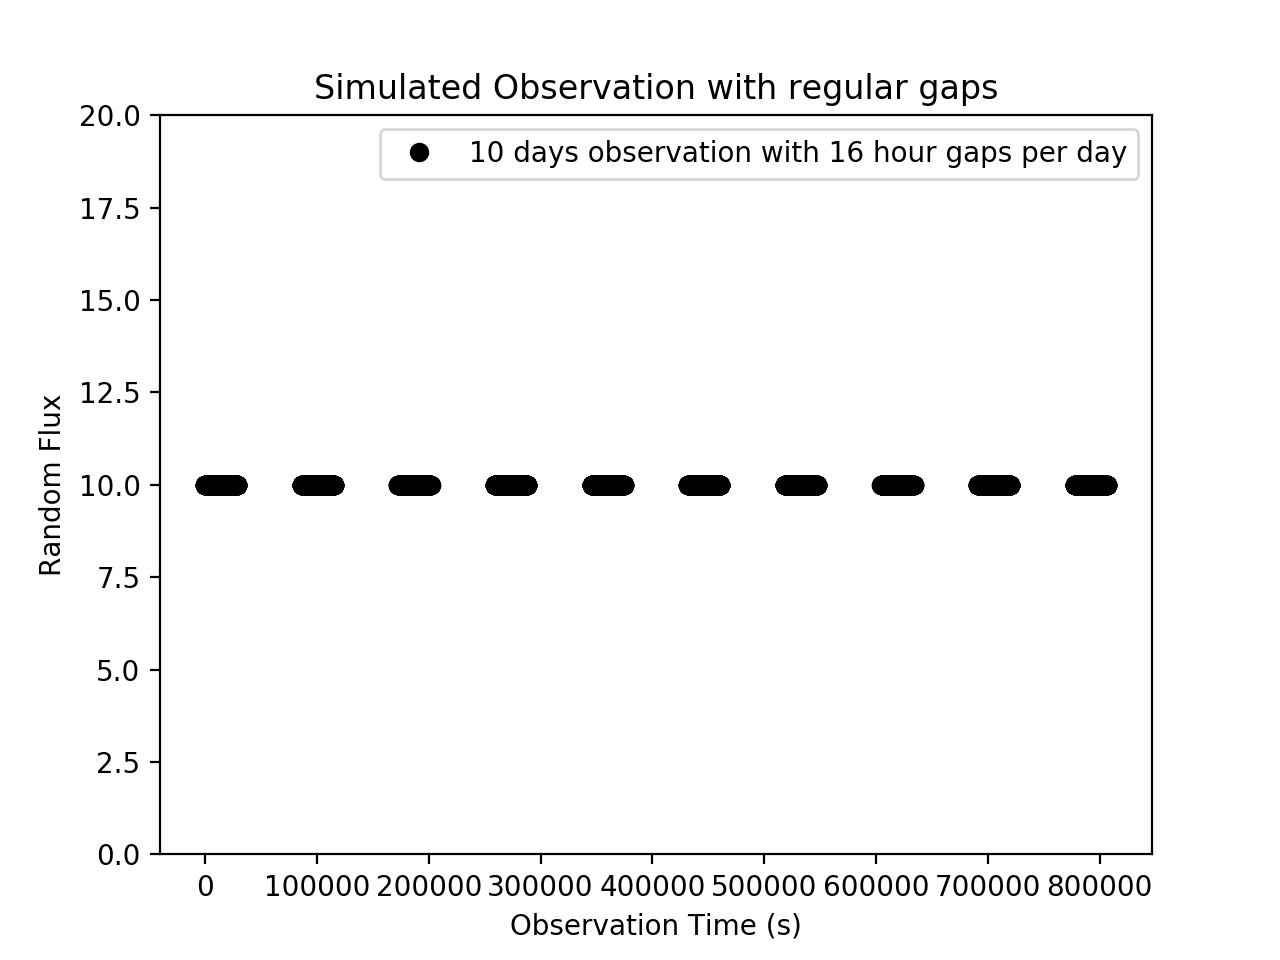

In [24]:
sim_obs(obs_days=10, obs_window_length=8)

Once we have an observation, we simply call the completeness function, input the time series data and give a P_max limit to simulate upto. The function neatly provides a progress bar for each execution procedure it goes under and finally spits out the transit detection probability along with its completeness factor!

9 number of gaps found greater than 10.0 mins


Area under the curve is 7.63
Area if probability is 1 for all is 24.0
Completeness factor for this plot is 0.32


<IPython.core.display.Javascript object>


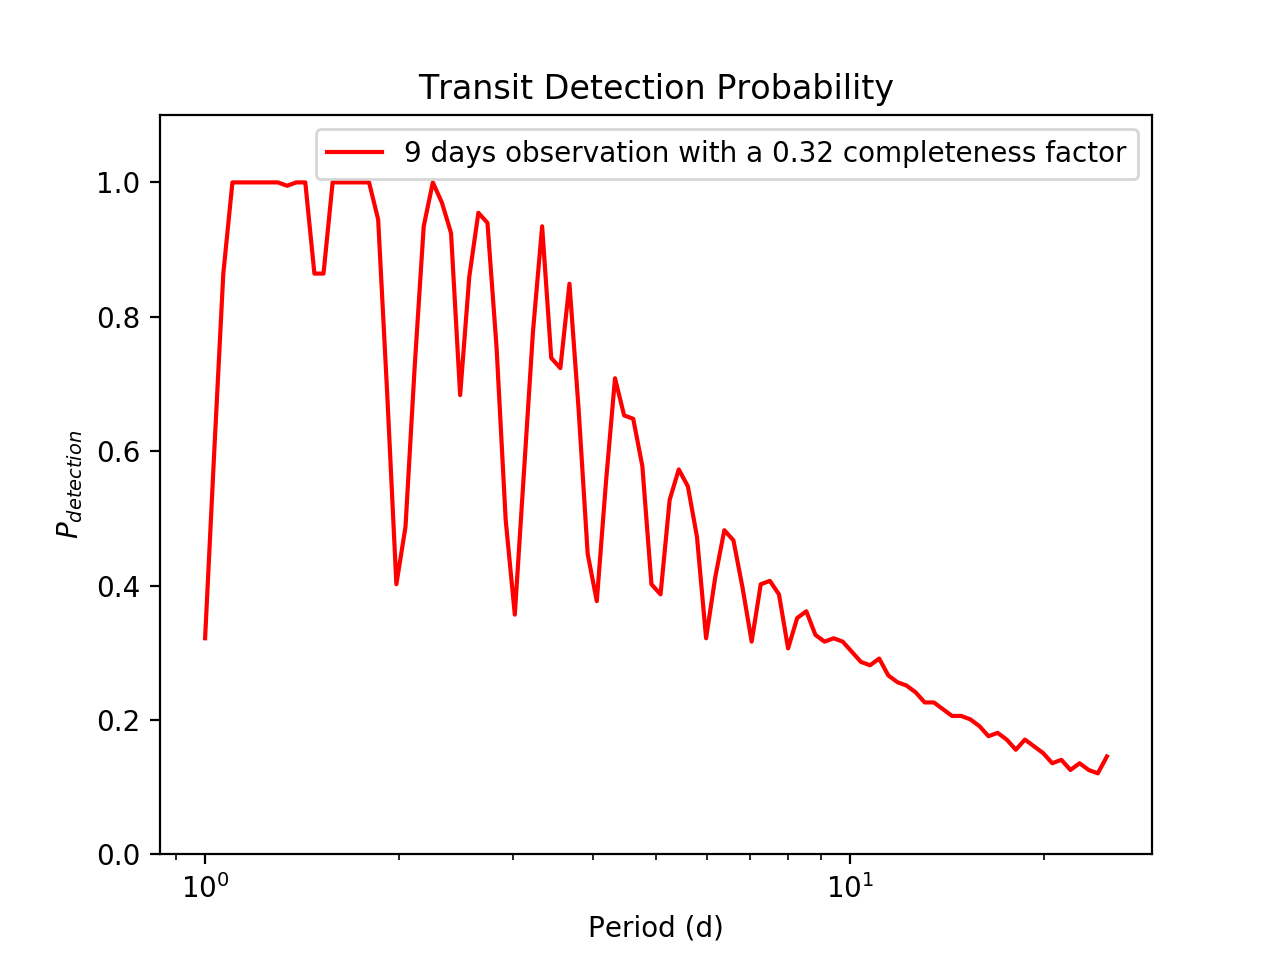

<IPython.core.display.Javascript object>


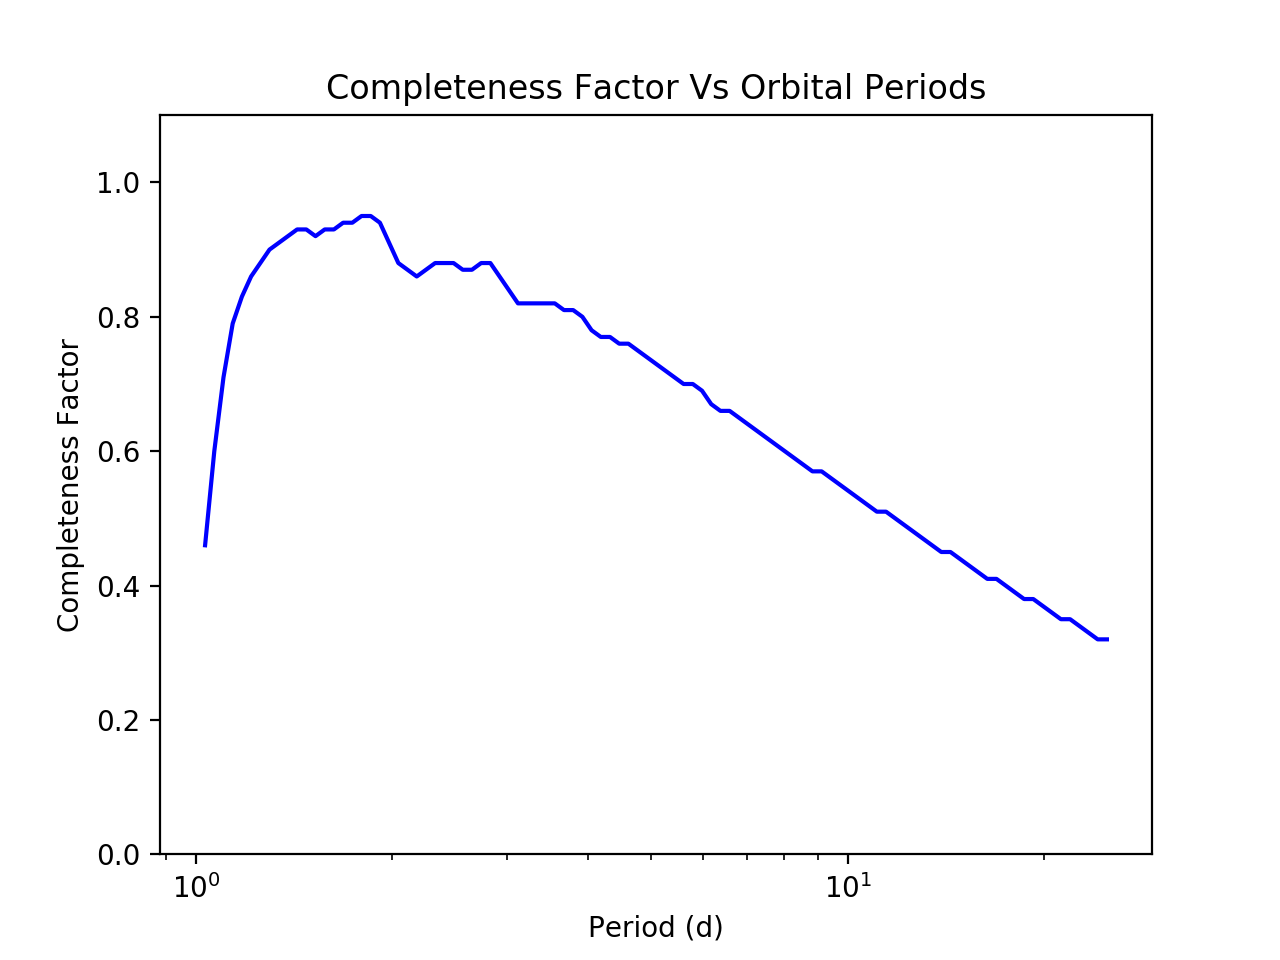

In [25]:
completeness(data, P_max=25, completeness_vs_period_plot='yes')